In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

from collections import defaultdict
from multi_gridworld import MutliGridworldEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = MutliGridworldEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [20]:
def sarsa(env, num_episodes, REWARD_WEIGHT, DECAY = 1, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
   
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        REWARD_WEIGHT[0] = REWARD_WEIGHT[0] * 0.99
        REWARD_WEIGHT[1] = 1 - REWARD_WEIGHT[0]
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)

            reward = np.array(reward).dot(REWARD_WEIGHT)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done or t > 10000:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [21]:
def stat(stats):
    DEATHS = np.sum(np.array(stats.episode_lengths) > 100)
    print ('Deaths:', DEATHS)
    AVGS = np.convolve(stats.episode_lengths, np.ones((50,))/50, mode='valid')
    print ('Average Episode:', AVGS)
    REW = np.convolve(stats.episode_rewards, np.ones((50,))/50, mode='valid')
    print ('Average Reward:', REW)

In [22]:
import seaborn as sns
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

In [67]:
def plot_stats(stats_list, smoothing_window=20, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    smoothed = []
    labels = np.array(['R', 'F', '0.9R + 0.1F (λ=0.99)', '0.9R + 0.1F (λ=0.999)', '0.9R + 0.1F', 'Curriculum'])
    hour, direction = np.meshgrid(np.arange(len(stats_list[0].episode_lengths)), labels)
    df = pd.DataFrame({"Episodes": hour.flatten(), "Reward Functions": direction.flatten()})

    for stats in stats_list:
        episodes_smoothed = pd.Series(stats.episode_lengths).rolling(smoothing_window, 
                                                                     min_periods=smoothing_window).mean().as_matrix()
        smoothed = smoothed + episodes_smoothed.tolist()
    print (len(smoothed))
    print (len(df))
    df["Episode Length (Smoothed)"] = smoothed

    plt.figure(figsize=(12,8))
    g = sns.tsplot(df, time='Episodes', unit = "Reward Functions", condition='Reward Functions', value='Episode Length (Smoothed)')
    g.set(ylim=(0, 400))
    plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
    plt.setp(g.get_legend().get_title(), fontsize='24') # for legend title

Episode 500/500.

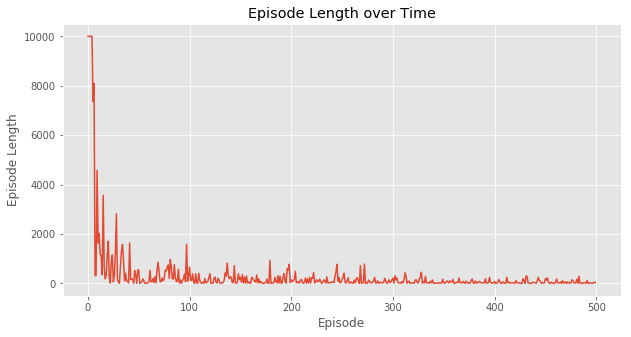

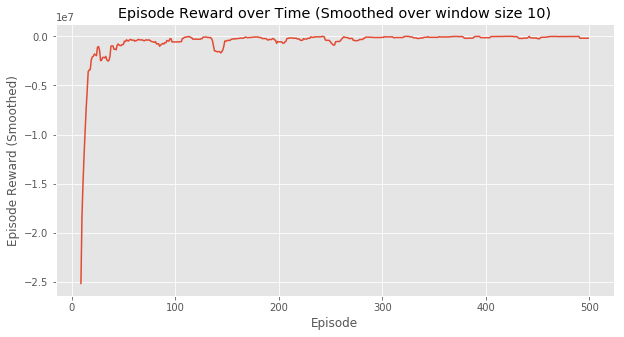

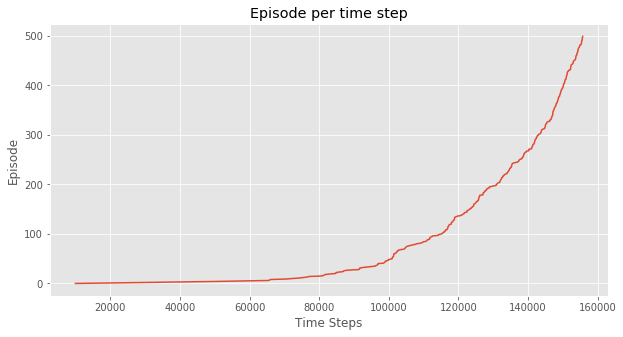

In [24]:
Q, stats = sarsa(env, 500, np.array([0, 1]))
plotting.plot_episode_stats(stats)
stats1 = stats

Episode 500/500.

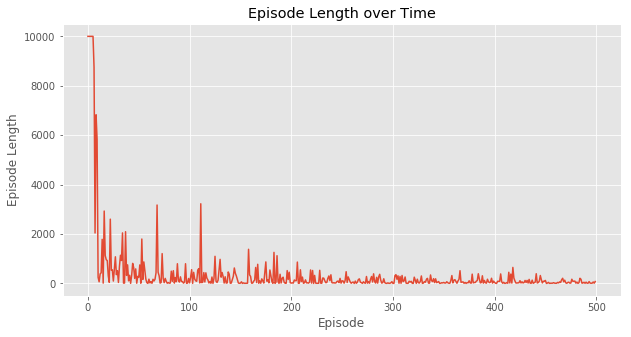

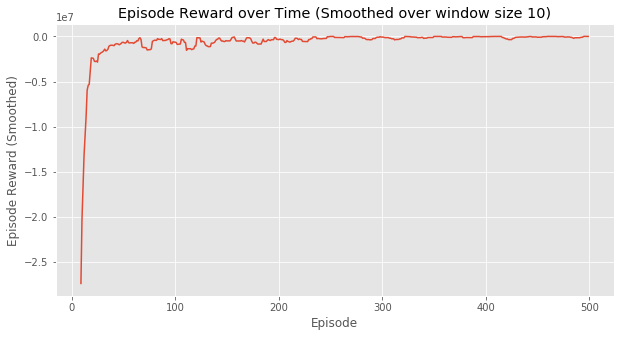

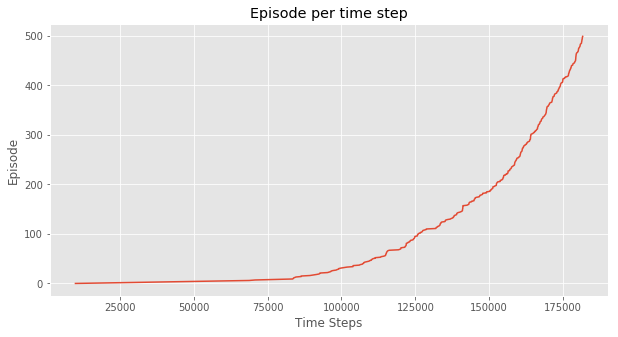

In [25]:
Q, stats = sarsa(env, 500, np.array([1, 0]))
plotting.plot_episode_stats(stats)
stats2 = stats

Episode 500/500.

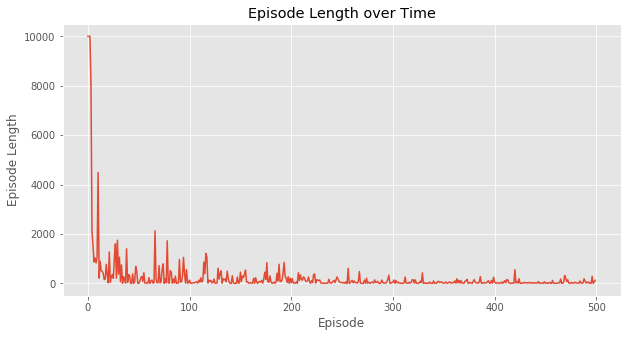

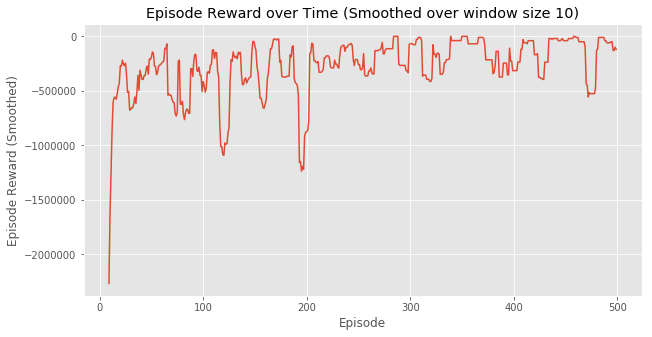

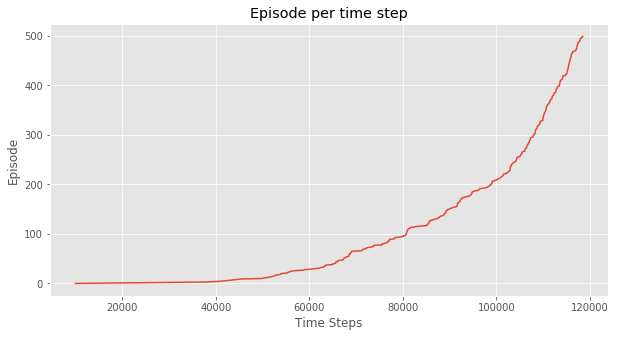

In [26]:
Q, stats = sarsa(env, 500, np.array([0.9, 0.1]), 0.99)
plotting.plot_episode_stats(stats)
stats3 = stats

In [ ]:
Q, stats = sarsa(env, 500, np.array([0.9, 0.1]), 0.999)
plotting.plot_episode_stats(stats)
stats4 = stats

Episode 500/500.

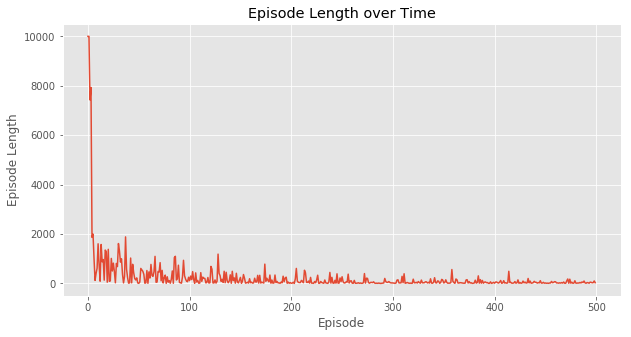

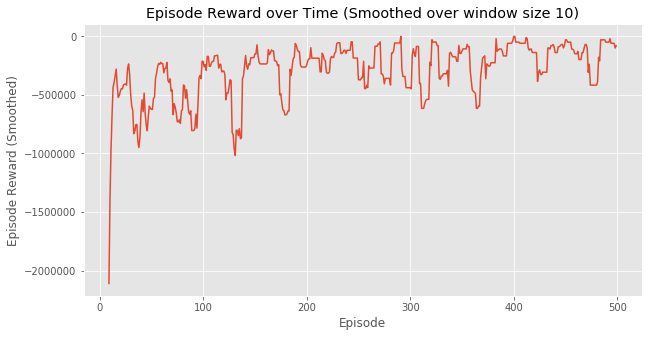

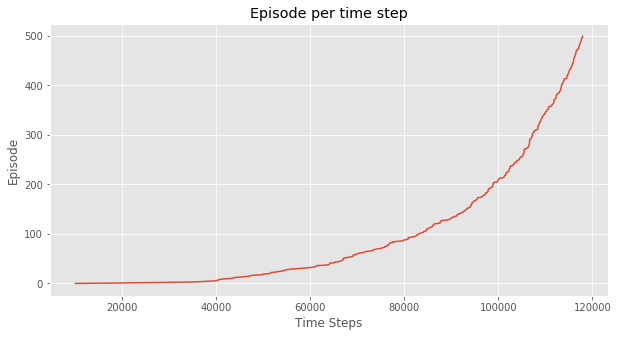

In [28]:
Q, stats = sarsa(env, 500, np.array([0.9, 0.1]))
plotting.plot_episode_stats(stats)
stats5 = stats

In [63]:
class Something:
    def __init__(self):
        self.episode_lengths = np.array([])

stats6 = Something()
stats6.episode_lengths = np.array([10001.0, 8721.0, 536.0, 1458.0, 564.0, 842.0, 205.0, 25.0, 268.0, 259.0, 144.0, 249.0, 594.0, 18.0, 307.0, 60.0, 33.0, 92.0, 125.0, 28.0, 95.0, 16.0, 599.0, 38.0, 10.0, 331.0, 123.0, 255.0, 16.0, 197.0, 50.0, 204.0, 819.0, 50.0, 403.0, 99.0, 591.0, 144.0, 142.0, 428.0, 408.0, 371.0, 259.0, 557.0, 216.0, 45.0, 476.0, 5.0, 21.0, 231.0, 218.0, 6.0, 222.0, 152.0, 356.0, 25.0, 321.0, 116.0, 12.0, 188.0, 96.0, 51.0, 473.0, 24.0, 25.0, 15.0, 49.0, 94.0, 6.0, 104.0, 159.0, 565.0, 19.0, 0.0, 29.0, 10.0, 25.0, 122.0, 16.0, 184.0, 663.0, 84.0, 78.0, 133.0, 80.0, 366.0, 7.0, 248.0, 245.0, 304.0, 77.0, 163.0, 522.0, 270.0, 30.0, 244.0, 13.0, 112.0, 190.0, 98.0, 165.0, 95.0, 13.0, 80.0, 25.0, 15.0, 14.0, 31.0, 13.0, 27.0, 66.0, 10.0, 15.0, 5.0, 76.0, 19.0, 102.0, 163.0, 10.0, 43.0, 503.0, 74.0, 180.0, 4.0, 1.0, 160.0, 80.0, 79.0, 324.0, 424.0, 134.0, 8.0, 16.0, 133.0, 243.0, 27.0, 20.0, 16.0, 14.0, 117.0, 56.0, 10.0, 44.0, 98.0, 35.0, 26.0, 34.0, 31.0, 27.0, 7.0, 142.0, 21.0, 143.0, 10.0, 104.0, 522.0, 304.0, 203.0, 14.0, 5.0, 15.0, 332.0, 123.0, 108.0, 175.0, 17.0, 23.0, 12.0, 15.0, 10.0, 10.0, 10.0, 7.0, 197.0, 8.0, 3.0, 24.0, 7.0, 299.0, 9.0, 81.0, 22.0, 78.0, 23.0, 10.0, 493.0, 74.0, 18.0, 159.0, 17.0, 37.0, 39.0, 143.0, 5.0, 116.0, 20.0, 14.0, 131.0, 50.0, 41.0, 1.0, 24.0, 205.0, 118.0, 207.0, 17.0, 34.0, 26.0, 51.0, 43.0, 6.0, 21.0, 12.0, 61.0, 12.0, 11.0, 158.0, 19.0, 4.0, 35.0, 239.0, 127.0, 82.0, 61.0, 23.0, 20.0, 15.0, 7.0, 44.0, 17.0, 280.0, 291.0, 50.0, 73.0, 107.0, 130.0, 4.0, 42.0, 32.0, 121.0, 11.0, 12.0, 131.0, 152.0, 80.0, 17.0, 3.0, 390.0, 12.0, 27.0, 13.0, 44.0, 10.0, 123.0, 9.0, 92.0, 1.0, 27.0, 117.0, 336.0, 21.0, 50.0, 81.0, 9.0, 32.0, 141.0, 11.0, 26.0, 90.0, 15.0, 25.0, 36.0, 17.0, 460.0, 13.0, 77.0, 27.0, 22.0, 18.0, 33.0, 9.0, 43.0, 61.0, 6.0, 113.0, 277.0, 139.0, 9.0, 9.0, 3.0, 10.0, 80.0, 131.0, 17.0, 20.0, 24.0, 18.0, 7.0, 11.0, 98.0, 186.0, 18.0, 20.0, 285.0, 182.0, 16.0, 12.0, 22.0, 10.0, 179.0, 132.0, 12.0, 16.0, 11.0, 17.0, 115.0, 19.0, 155.0, 118.0, 15.0, 14.0, 1.0, 49.0, 15.0, 206.0, 15.0, 11.0, 75.0, 3.0, 30.0, 106.0, 94.0, 31.0, 112.0, 83.0, 20.0, 14.0, 7.0, 15.0, 12.0, 93.0, 19.0, 45.0, 11.0, 91.0, 27.0, 84.0, 61.0, 66.0, 9.0, 10.0, 44.0, 35.0, 156.0, 44.0, 5.0, 30.0, 12.0, 108.0, 57.0, 110.0, 11.0, 101.0, 44.0, 186.0, 15.0, 7.0, 38.0, 84.0, 59.0, 18.0, 18.0, 32.0, 7.0, 19.0, 28.0, 135.0, 8.0, 103.0, 27.0, 11.0, 153.0, 136.0, 10.0, 70.0, 17.0, 197.0, 103.0, 9.0, 4.0, 25.0, 10.0, 6.0, 128.0, 12.0, 74.0, 25.0, 7.0, 8.0, 28.0, 10.0, 5.0, 11.0, 79.0, 60.0, 218.0, 10.0, 48.0, 27.0, 45.0, 11.0, 16.0, 17.0, 8.0, 5.0, 10.0, 9.0, 19.0, 16.0, 14.0, 21.0, 9.0, 74.0, 28.0, 33.0, 68.0, 114.0, 3.0, 36.0, 15.0, 107.0, 17.0, 16.0, 21.0, 58.0, 8.0, 26.0, 4.0, 20.0, 18.0, 50.0, 78.0, 15.0, 11.0, 9.0, 69.0, 11.0, 61.0, 152.0, 35.0, 2.0, 3.0, 123.0, 25.0, 7.0, 103.0, 49.0, 3.0, 8.0, 12.0, 23.0, 47.0, 59.0, 14.0, 57.0, 21.0, 13.0, 8.0, 6.0, 10.0, 13.0, 36.0, 17.0, 10.0, 28.0, 12.0, 329.0, 12.0, 35.0, 13.0, 3.0, 100.0, 19.0, 15.0, 5.0, 86.0, 27.0, 2.0, 18.0, 72.0, 3.0, 26.0, 91.0, 185.0, 69.0, 17.0, 39.0, 10.0, 28.0, 9.0])

3000
3000


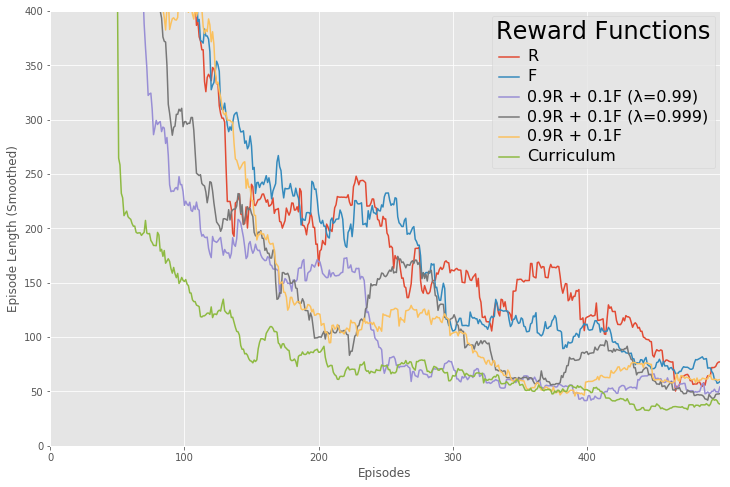

In [68]:
stats_list = [stats1, stats2, stats3, stats4, stats5, stats6]
plot_stats(stats_list, 50)